In [3]:
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn.functional as F
from torch import Tensor, nn
from torchsummary import summary
from torchvision.transforms import Compose, Resize, ToTensor

from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

from IPython.display import Image as IPython_Image

### load image and prep ###

In [4]:
img = Image.open('penguin.jpg')
# fig = plt.figure()
# plt.imshow(img)
# plt.show()

In [62]:
transform = Compose([
    Resize((224, 224)),
    ToTensor(),
])

org_x = transform(img)
x = org_x.unsqueeze(0)
print(org_x.shape)
print(x.shape)


torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


### patch embedding ###

In [86]:
class PatchEmbedding(nn.Module):
    def __init__(self, 
                 in_channels: int = 3, 
                 patch_size: int = 16, 
                 emb_size: int = 768): # latent D's dimension
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
                                nn.Conv2d(in_channels, 
                                          emb_size, 
                                          kernel_size=patch_size, 
                                          stride=patch_size),
                                Rearrange('b e (h) (w) -> b (h w) e'),
                                ) 
        # b e (h) (w) -> b (h w) e : 
        #     batch  embedding_size  height  width
        #     batch  height          width   embedding_size
        # this breaks down the image in s1xs2 patches, and then flat them
        
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size))
        
    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        # x is equal to patch embeddings
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        x = torch.cat([cls_tokens, x], dim=1) #prepending the class token
        x += self.positions
        return x    


### shape confirmation ###

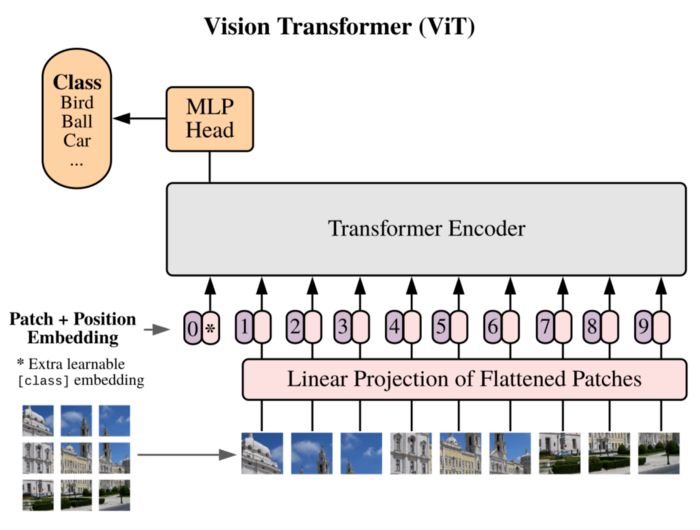

In [89]:
IPython_Image(filename = 'vit.png', width=400, height=200)

In [68]:
pe_obj = PatchEmbedding()
print(pe_obj.projection)
print(f'PatchEmbedding shape results : {pe_obj(x).shape}')

img_size=224; patch_size=16
positions = nn.Parameter(torch.randn((img_size// patch_size) **2 + 1, emb_size))
print(f'positions : {positions.shape}')

cls_token = nn.Parameter(torch.randn(1,1, emb_size))
print(f'cls_token : {cls_token.shape}')

# PatchEmbedding.projection을 거쳐서 나온 결과가 196 * 768
# + learnable [class] embedding -> 197 * 768

Sequential(
  (0): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (1): Rearrange('b e (h) (w) -> b (h w) e')
)
PatchEmbedding shape results : torch.Size([1, 196, 768])
positions : torch.Size([197, 768])
cls_token : torch.Size([1, 1, 768])


##### output of class #####

In [96]:
org_x = transform(img)
x = org_x.unsqueeze(0)

pe_obj = PatchEmbedding()
print(pe_obj.projection)
res = pe_obj(x)
print(f'PatchEmbedding shape results : {res.shape}')

Sequential(
  (0): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (1): Rearrange('b e (h) (w) -> b (h w) e')
)
PatchEmbedding shape results : torch.Size([1, 197, 768])


In [109]:
768/8

96.0

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self,
                 emb_size: int = 768,
                 num_heads: int = 8,
                 dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        if self.emb_size % self.num_heads != 0:
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" % (self.emb_size, self.num_heads))        
        
        '''
        self.qkv = nn.Linear(emb_size, 
                             emb_size * 3) 
                             # queries, keys and values matrix
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, 
                                    emb_size)
        '''
        self.attention_head_size = int(self.emb_size / self.num_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(self.emb_size, self.all_head_size)
        self.key = nn.Linear(self.emb_size, self.all_head_size)
        self.value = nn.Linear(self.emb_size, self.all_head_size)

        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(self.emb_size, self.all_head_size)

    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        qkv = rearrange(self.qkv(x), 
                        "b n (h d qkv) -> (qkv) b h n d", 
                        h=self.num_heads, 
                        qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        scaling = self.emb_size ** (1/2)
        
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        out = torch.einsum('bhal, bhlv -> bhav ', att, values) # sum over the third axis
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        
        return out
    

### class confirm ###

In [19]:
pe_obj = PatchEmbedding()
print(pe_obj(x).shape)
print(pe_obj.projection)

torch.Size([1, 196, 768])
Sequential(
  (0): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (1): Rearrange('b e (h) (w) -> b (h w) e')
)


### test ###

In [26]:
from einops import rearrange, reduce, repeat

transform = Compose([
    Resize((224, 224)),
    ToTensor(),
])

org_x = transform(img)
x = org_x.unsqueeze(0)
print(org_x.shape)
print(x.shape)
in_channels: int = 3
patch_size: int = 16
emb_size: int = 768
conv_obj = nn.Conv2d(in_channels,
                     emb_size,
                     kernel_size=patch_size,
                     stride=patch_size)
print(x.shape)
x = conv_obj(x)
print(x.shape)
# Rearrange(x, 'b e (h) (w) -> b (h w) e') # 클래스
rearrange(x, 'b e (h) (w) -> b (h w) e')   # 함수

print(x.shape)



torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 768, 14, 14])
torch.Size([1, 768, 14, 14])
